# IIE4123 HW2
## Kichang Lee(2019193016), School of Integrated Technology, Yonsei Univ

Language : Python3(Python 3.9.7 64-bit)

OS : Microsoft Windows 10 Education (10.0.19042)

Environment

CPU : Intel(R) Core(TM) i9-10850K CPU 3.60GHz, 3600Mhz, 10 Core with Intel(R) UHD Graphics 630

RAM : 64GB

GPU : RTX3090

## Notes about Task1

I checked the test accuracy for every epoch and I know it is not very good way, also it can be a cheating in model design, doesn't match with the perpose of using validation set. But just to make the task(b) easier, I did it. Also I've let the model to learn for 5000 epochs and you can see more clearly the 3 cases.

(a) You can check that out in the followed output result.

(b) The model and the dataset is quite simple so It was not really easy to find the epochs for each case but it seems like the 1~6 epoch can be classified to the underfit case, and about 10 epoch it looks robust fit case. And 100 epoch case can be a over fit case since the train loss is keep reducing but the validation loss is not followed.

1.under fit case

(epoch 003/100) Training Loss : 1.73950 | Validation Loss : 1.72737 | Test Loss : 1.70448 | Validation Accuracy : 78.33 % | Test Accyracy : 69.00 %

(epoch 004/100) Training Loss : 1.69898 | Validation Loss : 1.66935 | Test Loss : 1.64415 | Validation Accuracy : 88.33 % | Test Accyracy : 77.00 %

(epoch 005/100) Training Loss : 1.65149 | Validation Loss : 1.64506 | Test Loss : 1.62069 | Validation Accuracy : 86.67 % | Test Accyracy : 80.00 %

2.robust fit case

(epoch 010/100) Training Loss : 1.55042 | Validation Loss : 1.55637 | Test Loss : 1.54521 | Validation Accuracy : 90.00 % | Test Accyracy : 88.00 %

3.over fit case

(epoch 098/100) Training Loss : 1.49401 | Validation Loss : 1.52450 | Test Loss : 1.53244 | Validation Accuracy : 95.00 % | Test Accyracy : 90.00 %

(epoch 099/100) Training Loss : 1.49384 | Validation Loss : 1.52519 | Test Loss : 1.53280 | Validation Accuracy : 95.00 % | Test Accyracy : 92.00 %

(epoch 100/100) Training Loss : 1.49382 | Validation Loss : 1.52531 | Test Loss : 1.53853 | Validation Accuracy : 95.00 % | Test Accyracy : 91.00 %



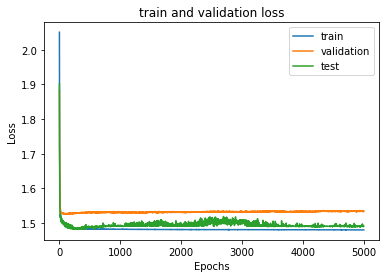

In [20]:
from IPython.display import Image

#Loss graph of 5000 epoch test 
Image("./5000epoch loss.png")

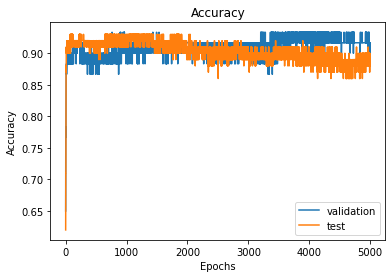

In [18]:
#Accuracy graph of 5000 epoch test
Image("./5000epoch acc.png")

# Import Packages

In [8]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

# Hyper-Parameters

In [9]:
BATCH_SIZE = 100
LEARNING_RATE = 0.001
EPOCHS = 100


USE_CUDA = torch.cuda.is_available() 
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") 
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


# Data Management

In [10]:
transform = transforms.Compose([transforms.ToTensor()]) # Rescaled into [0,1]

whole_train_set = dset.MNIST("./MNIST_data", train=True, transform=transform, download=False)
mnist_test = dset.MNIST("./MNIST_data", train=False, transform=transform, download=False)

mnist_train, mnist_val = train_test_split(whole_train_set, test_size = 0.1, stratify=whole_train_set.targets)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Model

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 15, bias=True),
            nn.Sigmoid()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(15, 10, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out
        
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

model = MLP()
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
LOSSES_TRAIN, LOSSES_VAL, LOSSES_TEST = [], [], []
ACCS_VAL, ACCS_TEST = [], []
train_sample_num = len(train_loader)
val_sample_num = len(val_loader)

start = time.time()

for epoch in tqdm(range(EPOCHS), desc="EPOCHS"):
    model.train()
    LOSS_TRACE_FOR_TRAIN, LOSS_TRACE_FOR_VAL, LOSS_TRACE_FOR_TEST = [], [], []
    for idx, batch in enumerate(train_loader):
        optimizer.zero_grad()

        X_train, Y_train = batch
        X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)

        Y_pred_train = model(X_train)
        Y_train = Y_train.squeeze(-1)

        LOSS_train = criterion(Y_pred_train, Y_train)

        LOSS_TRACE_FOR_TRAIN.append(LOSS_train.cpu().detach().numpy())
        LOSS_train.backward()
        optimizer.step()        

    with torch.no_grad():
        model.eval()

        Result_pred_val, Result_anno_val = [], []
        for idx, batch in enumerate(val_loader):
            X_val, Y_val = batch
            X_val, Y_val = X_val.to(DEVICE), Y_val.to(DEVICE)

            Y_pred_val = model(X_val)
            Y_val = Y_val.squeeze(-1)
            LOSS_val = criterion(Y_pred_val, Y_val)

            LOSS_TRACE_FOR_VAL.append(LOSS_val.cpu().detach().numpy())

            Y_pred_val_np  = Y_pred_val.to('cpu').detach().numpy()
            Y_pred_val_np  = np.argmax(Y_pred_val_np, axis=1).reshape(-1, 1)
            Y_val_np       = Y_val.to('cpu').detach().numpy().reshape(-1, 1)

            Result_pred_val.append(list(Y_pred_val_np[0]))
            Result_anno_val.append(list(Y_val_np[0]))
        
        Result_pred_test, Result_anno_test = [], []
        for idx, batch in enumerate(test_loader):
            X_test, Y_test = batch
            X_test, Y_test = X_test.to(DEVICE), Y_test.to(DEVICE)

            Y_pred_test = model(X_test)
            Y_test = Y_test.squeeze(-1)
            test_loss = criterion(Y_pred_test, Y_test)

            LOSS_TRACE_FOR_TEST.append(LOSS_val.cpu().detach().numpy())

            Y_pred_test_np  = Y_pred_test.to('cpu').detach().numpy()
            Y_pred_test_np  = np.argmax(Y_pred_test_np, axis=1).reshape(-1, 1)
            Y_test_np       = Y_test.to('cpu').detach().numpy().reshape(-1, 1)
            
            Result_pred_test.append(list(Y_pred_test_np[0]))
            Result_anno_test.append(list(Y_test_np[0]))

        ACC_VAL        = metrics.accuracy_score(Result_anno_val, Result_pred_val)
        ACC_TEST       = metrics.accuracy_score(Result_anno_test, Result_pred_test)

        AVG_LOSS_TRAIN = np.average(LOSS_TRACE_FOR_TRAIN)
        AVG_LOSS_VAL   = np.average(LOSS_TRACE_FOR_VAL)
        AVG_LOSS_TEST  = np.average(LOSS_TRACE_FOR_TEST)

        LOSSES_TRAIN.append(AVG_LOSS_TRAIN)
        LOSSES_VAL.append(AVG_LOSS_VAL)
        LOSSES_TEST.append(AVG_LOSS_TEST)
        ACCS_VAL.append(ACC_VAL)
        ACCS_TEST.append(ACC_TEST)

        print(f'(epoch {epoch + 1:03d}/{EPOCHS}) Training Loss : {AVG_LOSS_TRAIN:.5f} | Validation Loss : {AVG_LOSS_VAL:.5f} | Test Loss : {AVG_LOSS_TEST:.5f} | Validation Accuracy : {ACC_VAL*100:.2f} % | Test Accyracy : {ACC_TEST*100:.2f} %')
        # print(f'(epoch {epoch + 1}/{EPOCHS}) Validation Loss      : {AVG_LOSS_VAL:.5f}')
        # print(f'(epoch {epoch + 1}/{EPOCHS}) Test Loss            : {AVG_LOSS_TEST:.5f}')
        # print(f'(epoch {epoch + 1}/{EPOCHS}) Validation Accuracy  : {ACC_VAL*100:.2f} %')
        # print(f'(epoch {epoch + 1}/{EPOCHS}) Test Accyracy        : {ACC_TEST*100:.2f} %')
        # print()
end = time.time()
print(f"Training took {end-start:.2f} sec")
    

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 2.05425 | Validation Loss : 1.90373 | Test Loss : 1.89962 | Validation Accuracy : 65.00 % | Test Accyracy : 55.00 %
(epoch 002/100) Training Loss : 1.82422 | Validation Loss : 1.76197 | Test Loss : 1.73321 | Validation Accuracy : 75.00 % | Test Accyracy : 69.00 %
(epoch 003/100) Training Loss : 1.73950 | Validation Loss : 1.72737 | Test Loss : 1.70448 | Validation Accuracy : 78.33 % | Test Accyracy : 69.00 %
(epoch 004/100) Training Loss : 1.69898 | Validation Loss : 1.66935 | Test Loss : 1.64415 | Validation Accuracy : 88.33 % | Test Accyracy : 77.00 %
(epoch 005/100) Training Loss : 1.65149 | Validation Loss : 1.64506 | Test Loss : 1.62069 | Validation Accuracy : 86.67 % | Test Accyracy : 80.00 %
(epoch 006/100) Training Loss : 1.61298 | Validation Loss : 1.59330 | Test Loss : 1.57298 | Validation Accuracy : 88.33 % | Test Accyracy : 85.00 %
(epoch 007/100) Training Loss : 1.57749 | Validation Loss : 1.57643 | Test Loss : 1.56076 | Validation Accuracy 

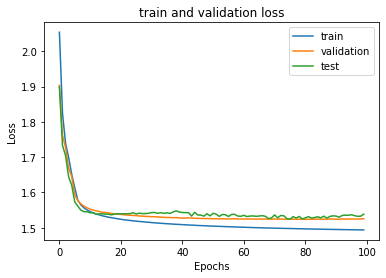

In [13]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('train and validation loss')
plt.plot(LOSSES_TRAIN, label = 'train')
plt.plot(LOSSES_VAL, label = 'validation')
plt.plot(LOSSES_TEST, label = 'test')
plt.legend()
plt.show()

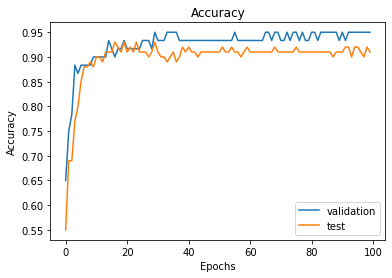

In [14]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.plot(ACCS_VAL, label = 'validation')
plt.plot(ACCS_TEST, label = 'test')
plt.legend()
plt.show()